# NATRE microstructure dataset

Study NATRE dataset, reproduce Ferrari & Polzin (2005)

In [1]:
%load_ext watermark
%matplotlib inline

import glob

import cf_xarray as cfxr
import dcpy
import distributed
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import tqdm
import xarray as xr
from IPython.display import Image

import eddydiff as ed

xr.set_options(keep_attrs=True)

plt.rcParams["figure.dpi"] = 140
plt.rcParams["savefig.dpi"] = 200
plt.style.use("ggplot")

%watermark -iv

matplotlib : 3.4.3
cf_xarray  : 0.5.3.dev29+g3660810.d20210729
dcpy       : 0.1
numpy      : 1.21.3
tqdm       : 4.62.3
distributed: 2021.10.0
xarray     : 0.17.1.dev3+g48378c4b1
eddydiff   : 0.1



In [2]:
if "client" in locals():
    client.cluster.close()
    client.close()
client = distributed.Client(n_workers=2, threads_per_worker=2)
client

/home/deepak/miniconda3/envs/dcpy/lib/python3.8/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44397 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:44397/status,
Dashboard: http://127.0.0.1:44397/status,Workers: 2
Total threads: 4,Total memory: 31.09 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45051,Workers: 2
Dashboard: http://127.0.0.1:44397/status,Total threads: 4
Started: Just now,Total memory: 31.09 GiB
Comm: tcp://127.0.0.1:35215,Total threads: 2
Dashboard: http://127.0.0.1:37419/status,Memory: 15.54 GiB
Nanny: tcp://127.0.0.1:46017,


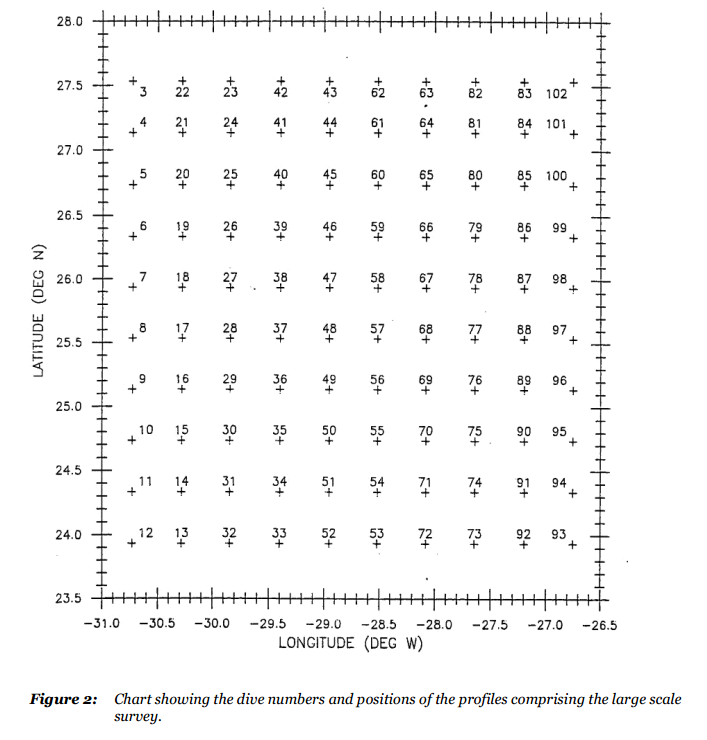

In [3]:
Image("../images/natre-large-scale.png")

## Read dataset

created using ``eddydiff.natre.combine_natre_files()``



In [4]:
natre = ed.natre.read_natre().load()

/home/deepak/work/python/xarray/xarray/core/computation.py:733: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)
/home/deepak/work/python/xarray/xarray/core/computation.py:733: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)


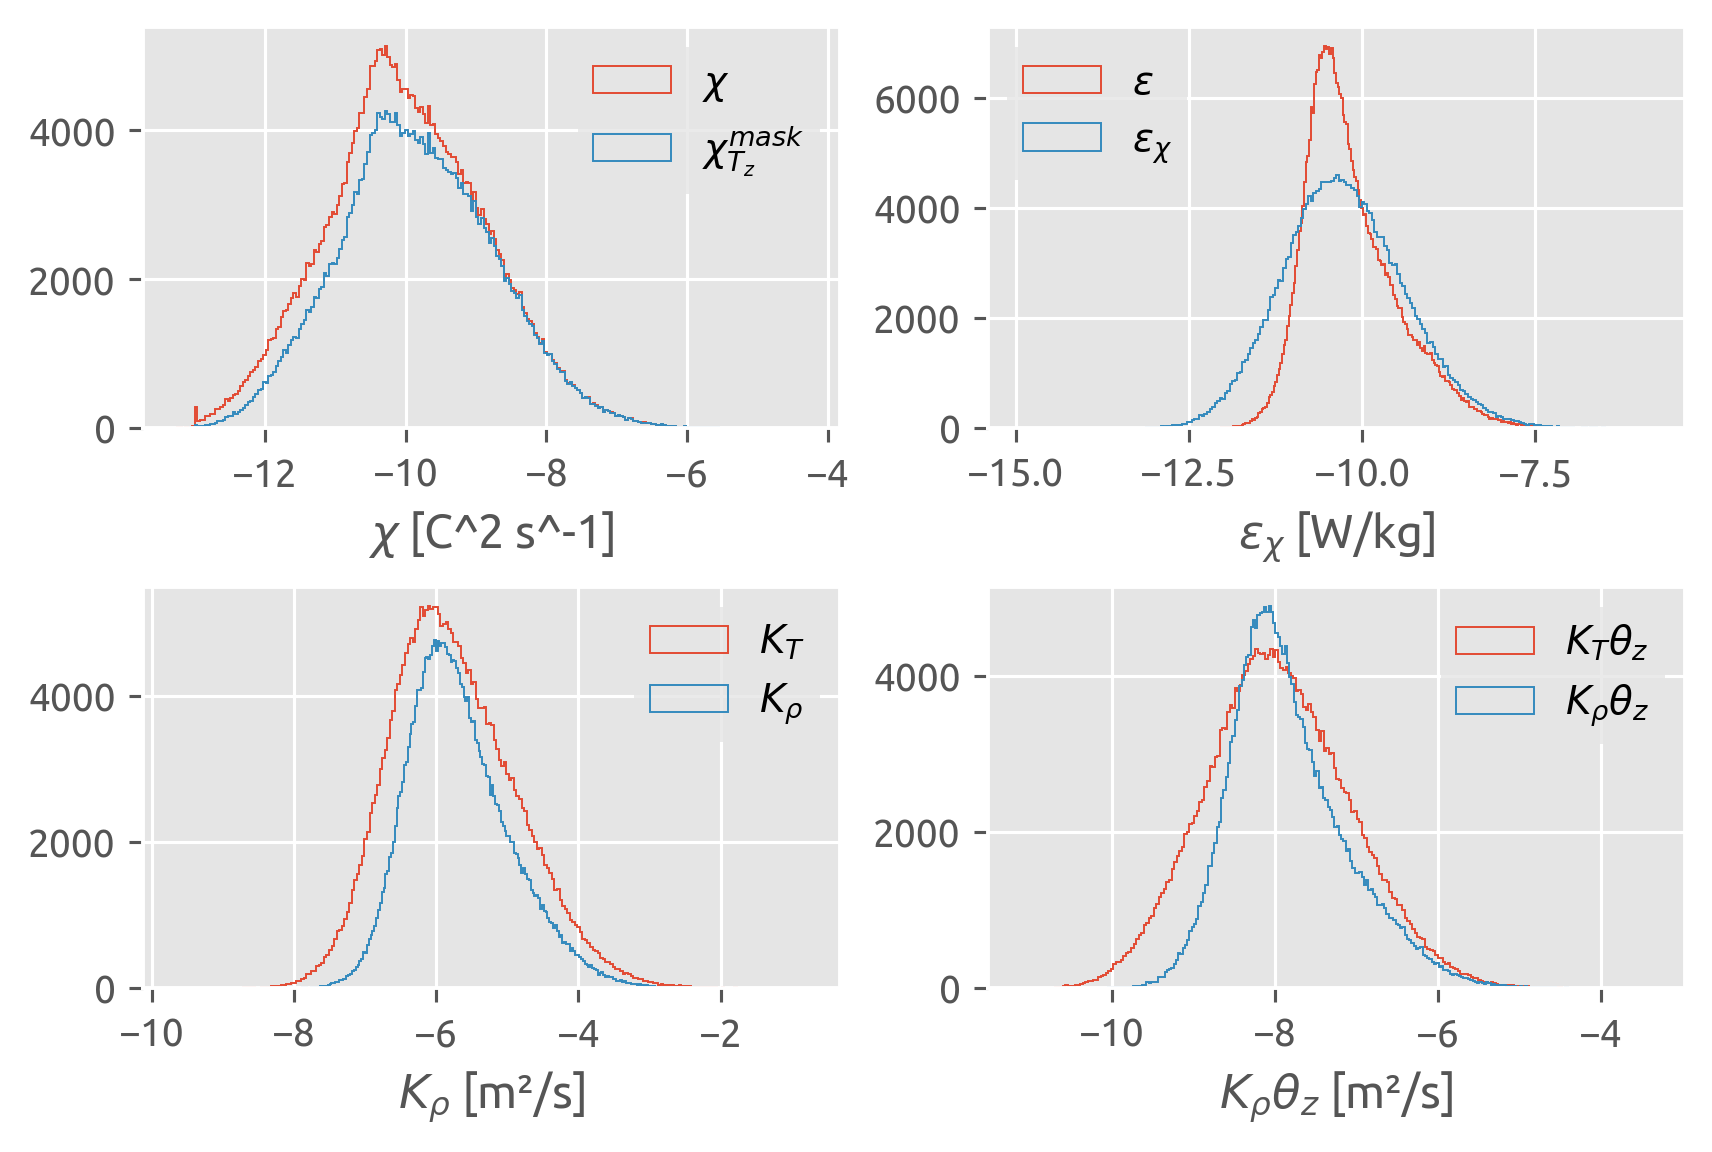

In [5]:
ed.plot.histogram_turb_estimates(natre)

## TS plot

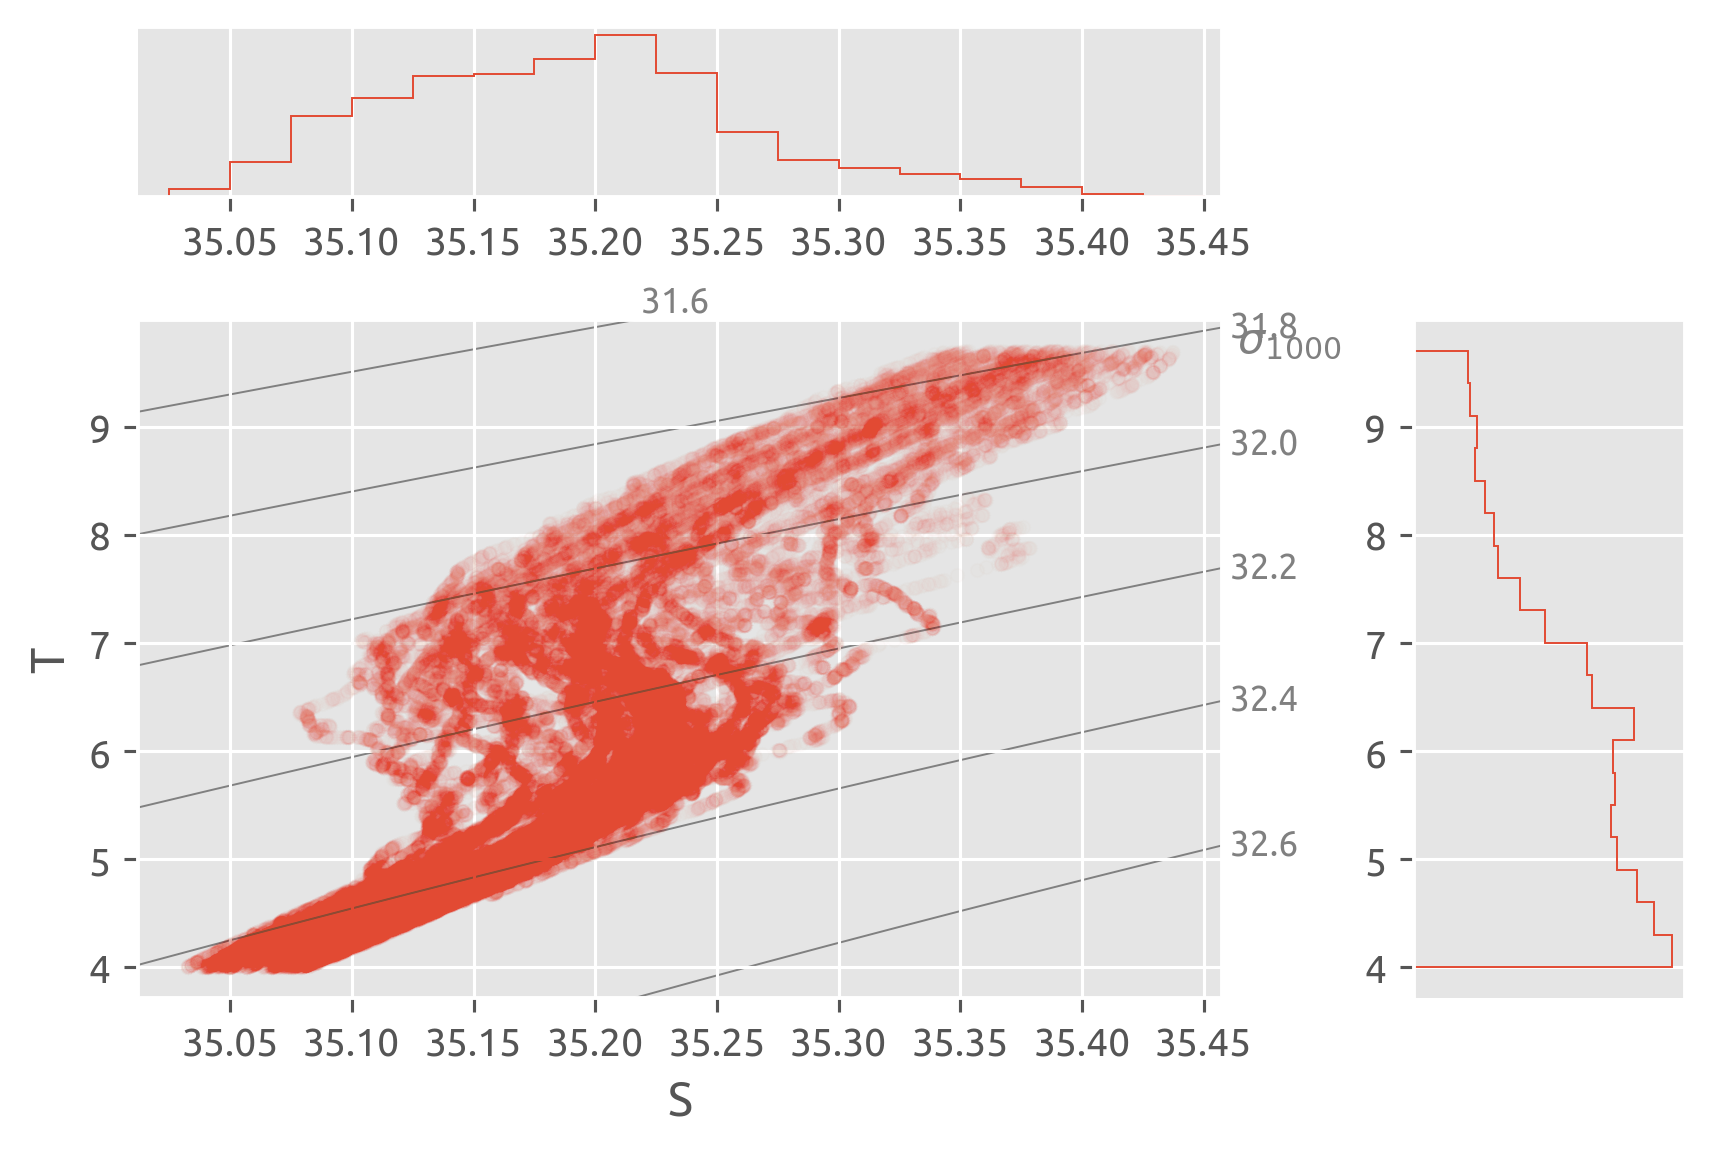

In [6]:
hdl, axes = dcpy.oceans.TSplot(
    natre.salt[::2],
    natre.theta[::2],
    Pref=1000,
    # rho_levels=bins,
    Sbins=np.arange(35, 35.5, 0.025),
    Tbins=np.arange(4, 10, 0.3),
    hexbin=False,
    plot_kwargs={"alpha": 0.01},
)

In [ ]:
(
    natre["chi"].rolling(depth=100, center=True, min_periods=1).mean().compute()
).plot.line(
    y="depth",
    col="longitude",
    row="latitude",
    yincrease=False,
    xlim=[1e-12, 1e-7],
    ylim=(2000, 0),
    xscale="log",
)

tornado.application - ERROR - Exception in callback functools.partial(<bound method IOLoop._discard_future_result of <zmq.eventloop.ioloop.ZMQIOLoop object at 0x7f70c8187340>>, <Task finished name='Task-481' coro=<Cluster._sync_cluster_info() done, defined at /home/deepak/miniconda3/envs/dcpy/lib/python3.8/site-packages/distributed/deploy/cluster.py:104> exception=OSError('Timed out trying to connect to tcp://127.0.0.1:45051 after 3 s')>)
Traceback (most recent call last):
  File "/home/deepak/miniconda3/envs/dcpy/lib/python3.8/site-packages/distributed/comm/core.py", line 284, in connect
    comm = await asyncio.wait_for(
  File "/home/deepak/miniconda3/envs/dcpy/lib/python3.8/asyncio/tasks.py", line 498, in wait_for
    raise exceptions.TimeoutError()
asyncio.exceptions.TimeoutError

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/deepak/miniconda3/envs/dcpy/lib/python3.8/site-packages/tornado/ioloop.py", line 741

## Procedure

The large-scale average operator ⟨⟩ represents 
1. a horizontal average over the survey lateral scale,
2. a vertical average over O(100) m, and
3. a time average over the 18-day survey.


The mean fields are derived by averaging all variables along neutral-density surfaces $γ_n$

Mean vertical gradients $∂_z θ_m$, $∂_z S_m$, and $∂_z b_m$, are calculated from O(100)-m linear fits to $θ_m(z_n)$,
$S_m(z_n)$, and $b_m(z_n)$, where $z_n$ is the mean depth of each surface $γ_n$. 

large-scale temperature gradient $|∇_n θ_m|$ is estimated by fitting
a plane to the 100 stations in the 400 km × 400 km
large-scale survey grid and rms is computed as the standard deviation of the departures from the plane fit. 

In theory, these bins are approx. 100m apart in neutral density

### Choose bins

In [ ]:
# bins = (
#    natre.gamma_n.mean(["latitude", "longitude"])
#    .interp(depth=np.arange(150, 2001, 100))
#    .dropna("depth")
#    .data
# )

bins = ed.sections.choose_bins(natre.gamma_n, depth_range=np.arange(150, 2001, 100))
natre.gamma_n.stack({"latlon": ["latitude", "longitude"]}).drop("latlon").cf.plot(
    hue="latlon",
    y="depth",
    lw=0.5,
    add_legend=False,
    yincrease=False,
)
dcpy.plots.linex(bins)

## Make estimate

 
**Vertical gradients:** `ed.sections.fit1D`

> Mean vertical gradients $∂_z θ_m$, $∂_z S_m$, and $∂_z b_m$, are calculated from O(100)-m linear fits to $θ_m(z_n)$, $S_m(z_n)$, and $b_m(z_n)$, where $z_n$ is the mean depth of each surface $γ_n$. 

I don't understand this. The bins are O(100m) apart, so how do you "fit" straight lines over O(100)-m to a profile that has points every O(100)m.

**Horizontal gradients:** `ed.sections.fit2D`

large-scale temperature gradient $|∇_n θ_m|$ is estimated by fitting
a plane to the 100 stations in the 400 km × 400 km
large-scale survey grid and rms is computed as the standard deviation of the departures from the plane fit. 

Ke is totally wrong!, I need to fix my plane fitting

### Bin-average in density bins

In [ ]:
micro = ed.sections.bin_average_vertical(
    natre.reset_coords("pres"), "neutral_density", bins
)
micro

Replicate some Ferrari & Polzin (2005) figures. $K_ρ, ε$ look OK. $K_e$ is wrong, something is wrong with my slope estimate / plane fitting

In [ ]:
f, ax = plt.subplots(1, 3, sharey=True, constrained_layout=True)
micro.drop_vars("pres").Krho_m.cf.plot.step(xscale="log", xlim=(4e-6, 1e-4), ax=ax[0])
micro.drop_vars("pres").eps.cf.plot.step(ax=ax[1], xscale="log")
# chidens["Ke"].cf.plot(ax=ax[2])